In [55]:
import pdf2image
import os
from pdf2image import convert_from_path
#import pytesseract as tess 
# Importing the Image module from the PIL package to work with images
from PIL import Image
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import re
import shutil

In [32]:
path_img = r"D:\git\sipatho-rpa-scan\rename\image"
pdf_origin_path = r"D:\git\sipatho-rpa-scan\rename\raw"

In [24]:
def read_pdf(file_name):   
    # Store all pages of one file here:
    pages = []

    try:
        # Convert the PDF file to a list of PIL images:
        print(file_name)
        images = convert_from_path(file_name, poppler_path=r"C:\Users\jewna\Downloads\Release-24.02.0-0\poppler-24.02.0\Library\bin")  
        print(images)
        # Extract text from each image:
        for i, image in enumerate(images):
            print(i, image)
          # Generating filename for each image
            filename = path_img+r"\page_" + str(i) + "_" + os.path.basename(file_name) + ".jpeg" 
            print(filename) 
            image.save(filename, "JPEG")  

            break
          # Saving each image as JPEG
            #text = tess.image_to_string(Image.open(filename))  # Extracting text from each image using pytesseract
            #pages.append(text)  
          # Appending extracted text to pages list

    except Exception as e:
        print(str(e))

    img = cv2.imread(filename)
    print(img.shape) # Print image shape
    # cv2.imshow("original", img)
    
    # Cropping an image
    cropped_image = img[0:300, 1100:1659]
    
    # Display cropped image
    # cv2.imshow("cropped", cropped_image)
    plt.imshow(cropped_image)
    plt.show()
    
    # Save the cropped image
    cv2.imwrite("Cropped_Image.jpg", cropped_image)

    reader = easyocr.Reader(['en'])

    # Open an image file
    result = reader.readtext('Cropped_Image.jpg')

    # Print the extracted text
    for detection in result:
        if re.search("[A-Z]{1,3}[0-9]{8}", detection[1]):
            new_name = re.search("[A-Z]{1,3}[0-9]{8}", detection[1]).group(0)
            print(detection[1])
            print(re.search("[A-Z]{1,3}[0-9]{8}", detection[1]).group(0))


        


In [ ]:
def copy_and_rename(src_path, dest_path, new_name):
    # Copy the file
    shutil.copy(src_path, dest_path)
 
    # Rename the copied file
    new_path = f"{dest_path}/{new_name}"
    shutil.move(f"{dest_path}/{src_path}", new_path)
 
# Example usage
source_file = "example.txt"
destination_folder = "destination_folder"
new_file_name = "renamed_example.txt"
 
copy_and_rename(source_file, destination_folder, new_file_name)
print("Successfully Created File and Rename")

In [21]:
#print function returns the final converted text 
pdf_file = r".\raw\1.pdf"
print(read_pdf(pdf_file))

.\raw\1.pdf
[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1659x2346 at 0x1FA12D00950>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1646x2380 at 0x1FA321696D0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1646x2380 at 0x1FA321680D0>]
0 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1659x2346 at 0x1FA12D00950>
D:\git\sipatho-rpa-scan\rename\image\page_0_1.pdf.jpeg
1 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1646x2380 at 0x1FA321696D0>
D:\git\sipatho-rpa-scan\rename\image\page_1_1.pdf.jpeg
2 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1646x2380 at 0x1FA321680D0>
D:\git\sipatho-rpa-scan\rename\image\page_2_1.pdf.jpeg
.\raw\1.txt


In [28]:

for file in glob.glob(pdf_origin_path + "\*.pdf"):
  # pdf_name = file
  print(read_pdf(file))

D:\git\sipatho-rpa-scan\rename\raw\1.pdf
[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1659x2346 at 0x1FA31FBC990>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1646x2380 at 0x1FA321D81D0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1646x2380 at 0x1FA321D8F10>]
0 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1659x2346 at 0x1FA31FBC990>
D:\git\sipatho-rpa-scan\rename\image\page_0_1.pdf.jpeg
D:\git\sipatho-rpa-scan\rename\raw\1.txt
D:\git\sipatho-rpa-scan\rename\raw\2.pdf
[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2354 at 0x1FA321D8910>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1655x2366 at 0x1FA321D9310>]
0 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2354 at 0x1FA321D8910>
D:\git\sipatho-rpa-scan\rename\image\page_0_2.pdf.jpeg
D:\git\sipatho-rpa-scan\rename\raw\2.txt
D:\git\sipatho-rpa-scan\rename\raw\3.pdf
[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1655x2359 at 0x1FA32195190>, <PIL.PpmImagePlugin.PpmI

(2346, 1659, 3)


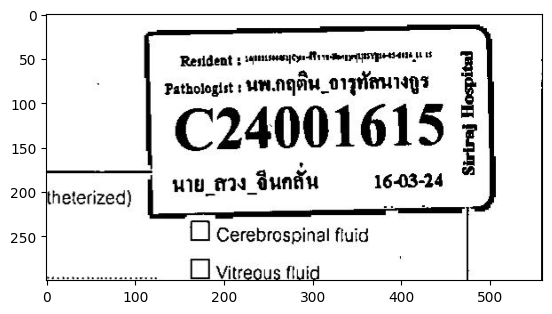

True

In [44]:
img = cv2.imread(r'D:\git\sipatho-rpa-scan\rename\image\page_0_1.pdf.jpeg')
print(img.shape) # Print image shape
# cv2.imshow("original", img)
 
# Cropping an image
cropped_image = img[0:300, 1100:1659]
 
# Display cropped image
# cv2.imshow("cropped", cropped_image)
plt.imshow(cropped_image)
plt.show()
 
# Save the cropped image
cv2.imwrite("Cropped Image.jpg", cropped_image)

In [54]:
# Create an OCR reader
reader = easyocr.Reader(['en'])

# Open an image file
result = reader.readtext('Cropped_Image.jpg')

# Print the extracted text
for detection in result:
    if re.search("[A-Z]{1,3}[0-9]{8}", detection[1]):
        print(detection[1])
        print(re.search("[A-Z]{1,3}[0-9]{8}", detection[1]).group(0))

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


C24001615 |
C24001615
